In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm
import torch
from torch.utils.data import dataloader
from kobert_transformers import get_tokenizer
from torch.utils.data import Dataset # 데이터로더
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import AdamW
from transformers import BertPreTrainedModel
from kobert_transformers import get_kobert_model, get_distilkobert_model
from transformers import BertModel, BertConfig, GPT2Config
from tqdm import tqdm

In [3]:
torch.cuda.is_available()

True

In [9]:
#KoBERT
kobert_config = {
    'attention_probs_dropout_prob': 0.1,
    'hidden_act': 'gelu',
    'hidden_dropout_prob': 0.1,
    'hidden_size': 768,
    'initializer_range': 0.02,
    'intermediate_size': 3072,
    'max_position_embeddings': 128,
    'num_attention_heads': 12,
    'num_hidden_layers': 12,
    'type_vocab_size': 2,
    'vocab_size': 60000
}

In [5]:
def kobert_input(tokenizer, str, device = None, max_seq_len = 128): #kobert input
    index_of_words = tokenizer.encode(str)
    token_type_ids = [0] * len(index_of_words)
    attention_mask = [1] * len(index_of_words)

  # Padding Length
    padding_length = max_seq_len - len(index_of_words)

  # Zero Padding
    index_of_words += [0] * padding_length
    token_type_ids += [0] * padding_length
    attention_mask += [0] * padding_length
    data = {
        'input_ids': torch.tensor([index_of_words]).to(device),
        'token_type_ids': torch.tensor([token_type_ids]).to(device),
        'attention_mask': torch.tensor([attention_mask]).to(device),
    }
    
    return data

In [4]:
class YoutubeTextClassificationDataset(Dataset): #Train DataSET
    """Youtube Text Classification Dataset"""
    def __init__(self,
               file_path = "./data/youtube_topic_category_train_211220.csv",
               num_label = 18,
               device = 'gpu',
               max_seq_len = 128, #512 # KoBERT max_length
               tokenizer = None
               ):
        self.file_path = file_path
        self.device = device
        self.data =[]
        #self.tokenizer = tokenizer if tokenizer is not None else get_tokenizer()
        self.tokenizer = get_tokenizer()

        df = pd.read_csv(self.file_path, encoding='utf-8-sig')
        df = df.sample(frac=1,random_state=0)

        for title,topic_label in tqdm(zip(df['title'],df['topic_label'])):
            index_of_words = self.tokenizer.encode(title) #title
            token_type_ids = [0] * len(index_of_words)
            attention_mask = [1] * len(index_of_words)

            # Padding Length
            padding_length = max_seq_len - len(index_of_words)
            # Zero Padding
            index_of_words += [0] * padding_length
            token_type_ids += [0] * padding_length
            attention_mask += [0] * padding_length


            # Label
            label = topic_label
            data = {
                  'input_ids': torch.tensor(index_of_words).to(self.device),
                  'token_type_ids': torch.tensor(token_type_ids).to(self.device),
                  'attention_mask': torch.tensor(attention_mask).to(self.device),
                  'labels': torch.tensor(label).to(self.device)
                 }    
            self.data.append(data)
    
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        item = self.data[index]
        return item

In [6]:
def train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step+1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader, train_start_index):

            # data.to(device)
            optimizer.zero_grad()
            outputs = model(**data)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'loss': loss.item(),  # Loss 저장
                    'train_step': i,  # 현재 진행한 학습
                    'total_train_step': len(train_loader)  # 현재 epoch에 학습 할 총 train step
                }, save_ckpt_path)

    return np.mean(losses)

In [7]:
def predict(sentence): #Data List형태로 수정필요
    data = kobert_input(get_tokenizer(), sentence, device, 128)
    output = model(**data)
    logit = output
    softmax_logit = nn.Softmax(logit).dim
    softmax_logit = softmax_logit[0].squeeze()

    max_index = torch.argmax(softmax_logit).item()
    max_index_value = softmax_logit[torch.argmax(softmax_logit)].item()

    #answer_list = answer[category[str(max_index)]]
    #answer_len= len(answer_list)-1
    #answer_index = random.randint(0,answer_len)

    return max_index,max_index_value,softmax_logit

In [10]:
def get_kobert_config():
    return BertConfig.from_dict(kobert_config)

In [11]:
class KoBERTforSequenceClassfication(BertPreTrainedModel):
    def __init__(self,
                num_labels = 18, #분류할 토픽
                hidden_size = 768,
                hidden_dropout_prob = 0.1,
               ):
        super().__init__(get_kobert_config())

        self.num_labels = num_labels
        self.kobert = get_kobert_model()
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)

        self.init_weights()
        
    def forward(
          self,
          input_ids=None,
          attention_mask=None,
          token_type_ids=None,
          position_ids=None,
          head_mask=None,
          inputs_embeds=None,
          labels=None,
    ):
    
        outputs = self.kobert(
          input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids,
          position_ids=position_ids,
          head_mask=head_mask,
          inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [13]:
data_path = "./data/youtube_topic_category_train_211220.csv"
checkpoint_path ="./checkpoint"
save_ckpt_path = f"{checkpoint_path}/kobert_youtube_topic_classification_vocab_plus.pth"

In [15]:
n_epoch = 50          # Num of Epoch
batch_size = 16      # 배치 사이즈
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
save_step = 500 # 학습 저장 주기
learning_rate = 5e-6  # Learning Rate

# WellnessTextClassificationDataset 데이터 로더
dataset = YoutubeTextClassificationDataset(file_path=data_path, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.
202316it [01:25, 2353.02it/s]


Train(49): 100%|████████████████████████████████████████████| 12645/12645 [46:34<00:00,  4.53it/s, Loss: 0.000 (0.004)]


,loss
0,0.742966
1,0.248540
2,0.182162
3,0.144725
4,0.118497
5,0.098066
6,0.082024
7,0.068699
8,0.056433
9,0.048068


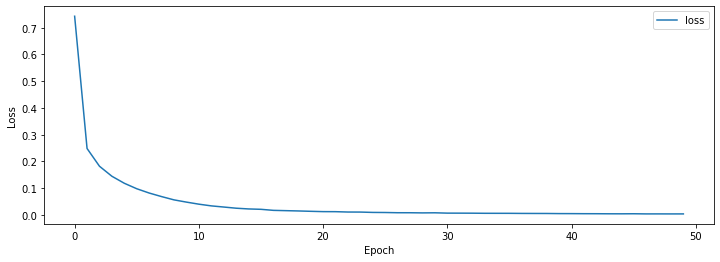

In [17]:
model = KoBERTforSequenceClassfication()
model.to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    # pre_loss = checkpoint['loss']
    train_step =  checkpoint['train_step']
    total_train_step =  checkpoint['total_train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")  #, loss={pre_loss}\n")
    # best_epoch += 1

losses = []
offset = pre_epoch
for step in range(n_epoch):
    epoch = step + offset
    loss = train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
    losses.append(loss)

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 테스트 데이터

In [ ]:
df_test = pd.read_csv('./data/130mil_videos.csv',encoding='utf-8-sig')

In [ ]:
df_test['title'][100000]

In [ ]:
predict(df_test['title'][100000])